## Project 2 - Ames Housing Data

Project notebook organisation:<br>
<a href='./1_Data_Cleaning_and_Feature_Engineering.ipynb'>1 Data Cleaning and Feature Engineering</a><br>
**2 Regression Models** (current notebook)<br>
<a href='./3_Visualisation_and_Insights.ipynb'>3 Visualisation and Insights</a><br>
<br>

### This notebook's layout
<a href='#create'>Model Prep: Create our features matrix x and target vector y</a>	
<a href='#split'>Model Prep: Train/test split</a><br>
<a href='#scaling'>Model Prep: Scaling</a><br>
<a href='#Instantiate'>Model Prep: Instantiate our models</a><br>
<a href='#x_valid'>Cross validation</a><br>
<a href='#model_fit'>Model Fitting and Evaluation</a><br>
<a href='#take_away'>Technical take-aways</a><br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline

### Load the Data


In [2]:
y_train_original = pd.read_csv('../data/y_train.csv')
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')

<a id='create'></a>
### Model Prep: Create our features matrix (`X`) and target vector (`y`)

In [3]:
features = [col for col in train._get_numeric_data().columns if col != 'SalePrice']
X = train[features]
y = y_train_original['SalePrice']

In [4]:
test.shape

(879, 312)

<a id='split'></a>
### Model Prep: Train/test split
---

We always want to have a holdout set to test our model. Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

<a id='scaling'></a>
### Model Prep: Scaling
---
Two methods for scaling were tried: 
1. `StandardScaler` - the standard way to scale data
2. `RobustScaler` - is robust to outliers

To try iterations robuster scaler vs Standscaler

In [6]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [7]:
# Standard Scaler got better metrics as compared to Robust scaler in all tried iterations
#rs = RobustScaler()
#rs.fit(X_train)
#X_train = rs.transform(X_train)
#X_test = rs.transform(X_test)

<a id='Instantiate'></a>
### Model Prep: Instantiate our models
---

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

In [8]:
# Find an optimal value for Ridge regression alpha using RidgeCV

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

print(optimal_ridge.alpha_)

172.25859653987874


In [9]:
# Find an optimal value for Lasso regression alpha using RidgeCV

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

303.17552295886327


In [10]:
# Find an optimal value for ElasticNet regression alpha using RidgeCV
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10)
                            
optimal_enet.fit(X_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio)

302.7095571344011
[0.01    0.05125 0.0925  0.13375 0.175   0.21625 0.2575  0.29875 0.34
 0.38125 0.4225  0.46375 0.505   0.54625 0.5875  0.62875 0.67    0.71125
 0.7525  0.79375 0.835   0.87625 0.9175  0.95875 1.     ]


<a id='x_valid'></a>
### Cross validation
---

Use `cross_val_score` to evaluate all three models.

In [11]:
# Cross-validate the Ridge regression 𝑅2 with the optimal alpha

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.90741707 0.93130567 0.89711498 0.94357015 0.86663223 0.93279554
 0.92078291 0.91262548 0.91765451 0.90025287]
0.9130151413071653


In [12]:
# Cross-validate the Lasso 𝑅2 with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.909062   0.93776398 0.89405332 0.94727969 0.86630817 0.93585468
 0.9198433  0.91758519 0.92083205 0.90572733]
0.9154309710612637


In [13]:
# Cross-validate the ElasticNet regression R^2 with the optimal alpha

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)

print(enet_scores)
print(np.mean(enet_scores))


[0.90905097 0.93776095 0.89405271 0.94728599 0.86632294 0.93585496
 0.91985039 0.9175791  0.92082645 0.90572743]
0.9154311898834478


In [14]:
def r2_adj(y_true, y_preds, p):
    """Returns adjusted R-squared"""
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return 1 - numerator / denominator

def get_metrics(y_true, y_pred,p):
    """Returns regression metrics"""
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    print('Root mean squared error = ', rmse)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)

<a id='model_fit'></a>
### Best Model Fitting
---

`ElasticNet` seems to be doing the best, so let's move forward with that model. Fit the model to the training data, and evaluate the training and test scores below.

In [15]:
enet.fit(X_train, y_train)

ElasticNet(alpha=302.7095571344011, copy_X=True, fit_intercept=True,
           l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [16]:
pred = enet.predict(X_test)

In [17]:
# This ran with reference to the above defined function
get_metrics(y_test,pred,X_train.shape[1])

Root mean squared error =  20034.428037799484
R^2                     =  0.9365120162123617
Adjusted R^2            =  0.8374707615036457


In [18]:
#lasso.fit(X_train, y_train)

enet_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':enet.coef_,
                            'abs_coef':np.abs(enet.coef_)})
enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)
enet_coefs.head()

,variable,coef,abs_coef
32,totalSF,15711.717053,15711.717053
13,GrLivArea,14765.432188,14765.432188
132,OverallQual_9,11595.334243,11595.334243
124,OverallQual_10,9755.128067,9755.128067
3,YearBuilt,9577.068902,9577.068902


In [19]:
# Not alot of features 'zeroed-out'
print('Percent features zeroed out:', np.sum((enet.coef_ == 0))/float(X.shape[0]))

Percent features zeroed out: 0.06832601268911664


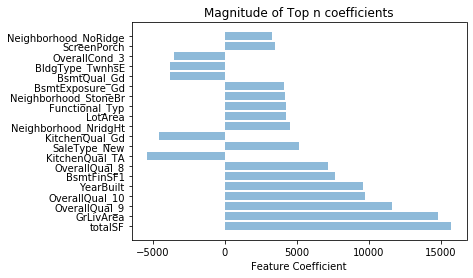

In [20]:
# PLotting a bar to show the magnitude of Top n coefficients
var = enet_coefs['variable'].head(20).tolist()
var_coef = enet_coefs['coef'].head(20).tolist()
y_pos = np.arange(len(var))

plt.barh(y_pos, var_coef, align='center', alpha=0.5)
plt.yticks(y_pos, var)
plt.rcParams["figure.figsize"] = [20,15]
plt.xlabel('Feature Coefficient')
plt.title('Magnitude of Top n coefficients')
plt.show()

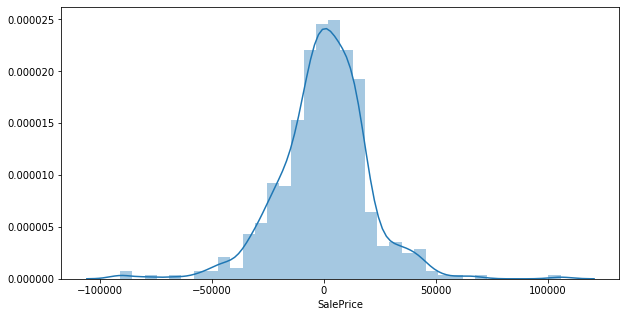

In [21]:
# Normality Check:Do the Residual Errors follow a normal distribution?
# The resultant plot mimics a normal distribution

residuals = y_test - pred
plt.figure(figsize=(10,5))
sns.distplot(residuals)

In [22]:
# Would be nice to check homoscedascitity

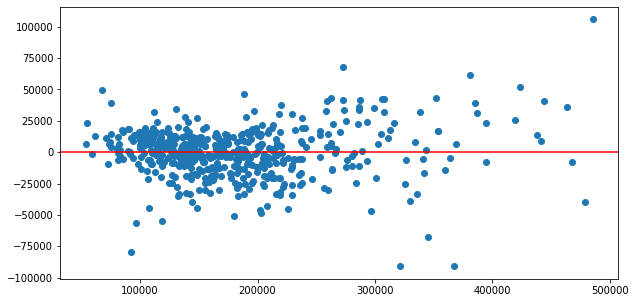

In [23]:
# Healthy residual plots
# Consistent variance between our low predictions and our high predictions (homoscedasticity)
# Pretty symmetrically distributed, clustering towards the middle of the plot

plt.figure(figsize=(10,5))
plt.scatter(pred, residuals)
plt.axhline(0, color='r')

In [24]:
ss = StandardScaler()
X = ss.fit_transform(test)

In [25]:
prediction = enet.predict(X)

In [26]:
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission['SalePrice'] = prediction
submission.head()

,Id,SalePrice
0,2658,136797.321510
1,2718,155749.236132
2,2414,216243.797623
3,1989,110559.537467
4,625,174704.220036


In [27]:
# export file
submission.to_csv('../data/submission_enet.csv',index=False)

![title](../misc/kaggle.jpg)